# Read and organize training data

In [1]:
import numpy as np
import pandas as pd
import glob
import datetime

## Septic (1) case

In [2]:
icu = pd.read_csv("../data/ICUSTAYS.csv")[["ICUSTAY_ID", "SUBJECT_ID", "INTIME"]]
patient = pd.read_csv("../data/PATIENTS.csv")[["SUBJECT_ID", "GENDER", "DOB"]]
patient_icu = pd.merge(icu, patient, how='inner', on="SUBJECT_ID")
patient_icu["DOB"] = pd.to_datetime(patient_icu["DOB"])
patient_icu["INTIME"] = pd.to_datetime(patient_icu["INTIME"])
patient_icu["AGE"] = patient_icu.apply(lambda x: (x.INTIME - x.DOB).days / 365, axis=1)
age_gender = patient_icu[["ICUSTAY_ID", "AGE", "GENDER"]]

In [3]:
def read_pos(x):
    pospath = glob.glob("../data/POS_FEAT" + str(x) + "/*.csv")
    pos = pd.concat((pd.read_csv(f) for f in pospath))[["ICUSTAY_ID", "ITEMID", "VALUENUM"]]
    pos = pos.groupby(["ICUSTAY_ID", "ITEMID"]).mean().reset_index()
    pivoted = pos.pivot(index="ICUSTAY_ID", columns="ITEMID", values="VALUENUM")
    pivoted = pivoted.reset_index()[["ICUSTAY_ID",220045,220050,220210,220277]].dropna()
    #pivoted = pd.merge(pivoted, age_gender, how='inner', on="ICUSTAY_ID")
    return pivoted.rename({220045: "HR" + str(x), 220050: "ABP" + str(x), 220210:"RR" + str(x), 220277: "SpO2" + str(x)}, axis='columns')

In [4]:
pos1 = read_pos(1)
pos2 = read_pos(2)
posall = pd.merge(pos1, pos2, how="inner", on="ICUSTAY_ID")
posall["HRdiff"] = posall["HR1"] - posall["HR2"]
posall["ABPdiff"] = posall["ABP1"] - posall["ABP2"]
posall["RRdiff"] = posall["RR1"] - posall["RR2"]
posall["SpO2diff"] = posall["SpO21"] - posall["SpO22"]
posall = pd.merge(posall, age_gender, how="inner", on="ICUSTAY_ID")
posall["GENDER"] = np.where(posall['GENDER'] == 'F', 0, 1)
posall["SEPSIS"] = 1

In [5]:
len(posall)

273

## Nonseptic (0) case

In [6]:
def read_neg(x):
    negpath = glob.glob("../data/NEG_FEAT" + str(x) + "/*.csv")
    everything = pd.concat((pd.read_csv(f) for f in negpath))
    neg = everything[["ICUSTAY_ID", "ITEMID", "VALUENUM"]]
    age_gen = everything[["ICUSTAY_ID", "AGE", "GENDER"]].drop_duplicates()
    neg = neg.groupby(["ICUSTAY_ID", "ITEMID"]).mean().reset_index()
    pivoted = neg.pivot(index="ICUSTAY_ID", columns="ITEMID", values="VALUENUM")
    pivoted = pivoted.reset_index()[["ICUSTAY_ID",220045,220050,220210,220277]].dropna()
    pivoted = pivoted.rename({220045: "HR" + str(x), 220050: "ABP" + str(x), 220210:"RR" + str(x), 220277: "SpO2" + str(x)}, axis='columns')
    return pd.merge(pivoted, age_gen, how="inner", on="ICUSTAY_ID")

In [7]:
neg1 = read_neg(1)
neg2 = read_neg(2)
negall = pd.merge(neg1, neg2, how="inner", on=["ICUSTAY_ID", "AGE", "GENDER"])
negall["HRdiff"] = negall["HR1"] - negall["HR2"]
negall["ABPdiff"] = negall["ABP1"] - negall["ABP2"]
negall["RRdiff"] = negall["RR1"] - negall["RR2"]
negall["SpO2diff"] = negall["SpO21"] - negall["SpO22"]
negall["GENDER"] = np.where(negall['GENDER'] == 'F', 0, 1)
negall["SEPSIS"] = 0

In [8]:
len(negall)

2151

In [9]:
df = pd.concat([posall, negall], sort=False)

## Train-test Split

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import *

In [11]:
y = df["SEPSIS"]
X = df.drop(["ICUSTAY_ID", "SEPSIS"], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
def classification_metrics(Y_pred, Y_true, Y_score):
    #NOTE: It is important to provide the output in the same order
    acc = accuracy_score(Y_true,Y_pred)
    bacc = balanced_accuracy_score(Y_true, Y_pred)
    auc_ = roc_auc_score(Y_true,Y_score)
    precision = precision_score(Y_true,Y_pred)
    recall = recall_score(Y_true,Y_pred)
    f1score = f1_score(Y_true,Y_pred)
    return acc, bacc, auc_, precision, recall, f1score

In [14]:
#import matplotlib
#matplotlib.use("TKAgg")
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize
    cmap = plt.cm.Blues

    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Normalized Confusion Matrix",
           ylabel='True', xlabel='Predicted')

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm.max() / 2.
    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, class_weight="balanced").fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)
y_score_lr = clf.predict_proba(X_test)[:,1]

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
acclr, bacclr, auclr, prelr, reclr, f1lr = classification_metrics(y_pred_lr, y_test, y_score_lr)
print(classification_metrics(y_pred_lr, y_test, y_score_lr))

(0.7690721649484537, 0.7551032956222331, 0.8173061157566814, 0.302158273381295, 0.7368421052631579, 0.4285714285714286)


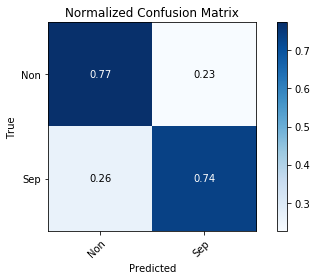

In [17]:
plot_confusion_matrix(y_test, y_pred_lr, ["Non","Sep"])

## Ada-boosted glm

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
bdt = AdaBoostClassifier(LogisticRegression(random_state=0, class_weight="balanced"), n_estimators=200, random_state=42)
bdt.fit(X_train, y_train)
y_pred_ab = bdt.predict(X_test)
y_score_ab = bdt.predict_proba(X_test)[:,1]

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
accab, baccab, aucab, preab, recab, f1ab = classification_metrics(y_pred_ab, y_test, y_score_ab)
print(classification_metrics(y_pred_ab, y_test, y_score_ab))

(0.7814432989690722, 0.7545089358911297, 0.8175110673880964, 0.31297709923664124, 0.7192982456140351, 0.4361702127659575)


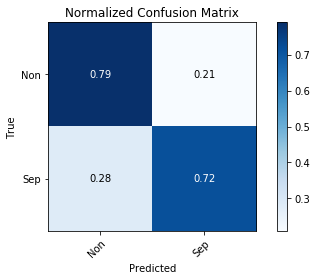

In [25]:
plot_confusion_matrix(y_test, y_pred_ab, ["Non","Sep"])

## SVM

In [26]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [27]:
clf = SVC(kernel="rbf",gamma="scale",class_weight="balanced",probability=True)
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)
y_score_svm = clf.predict_proba(X_test)[:,1]

In [28]:
accsv, baccsv, aucsv, presv, recsv, f1sv = classification_metrics(y_pred_svm, y_test, y_score_svm)
print(classification_metrics(y_pred_svm, y_test, y_score_svm))

(0.8041237113402062, 0.6989260534513855, 0.7560460731267421, 0.3137254901960784, 0.5614035087719298, 0.4025157232704403)


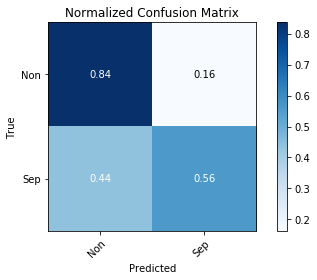

In [29]:
plot_confusion_matrix(y_test, y_pred_svm, ["Non","Sep"])

In [33]:
bdt = AdaBoostClassifier(SVC(kernel="rbf",gamma="scale",class_weight="balanced", probability=True), n_estimators=100, random_state=42)
bdt.fit(X_train, y_train)
y_pred_ab = bdt.predict(X_test)
y_score_ab = bdt.predict_proba(X_test)[:,1]

In [35]:
y_pred_ab

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## RF

In [42]:
rf = RandomForestClassifier(random_state=42, n_estimators=2000, max_depth=5, class_weight="balanced_subsample")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

In [43]:
accrf, baccrf, aucrf, prerf, recrf, f1rf = classification_metrics(y_pred_rf, y_test, y_score_rf)
print(classification_metrics(y_pred_rf, y_test, y_score_rf))

(0.8494845360824742, 0.7170232825053288, 0.8483357927529103, 0.3974358974358974, 0.543859649122807, 0.4592592592592592)


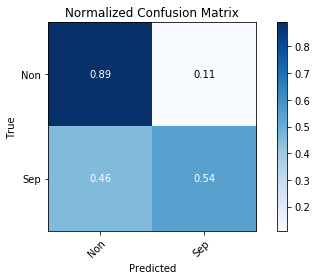

In [44]:
plot_confusion_matrix(y_test, y_pred_rf, ["Non","Sep"])

In [45]:
rf.feature_importances_

array([0.08786919, 0.1722188 , 0.17289495, 0.03409849, 0.0913955 ,
       0.10987893, 0.1237988 , 0.02552635, 0.03527686, 0.03864191,
       0.03859798, 0.02030639, 0.04735375, 0.00214208])

In [46]:
X_train.columns

Index(['HR1', 'ABP1', 'RR1', 'SpO21', 'HR2', 'ABP2', 'RR2', 'SpO22', 'HRdiff',
       'ABPdiff', 'RRdiff', 'SpO2diff', 'AGE', 'GENDER'],
      dtype='object')

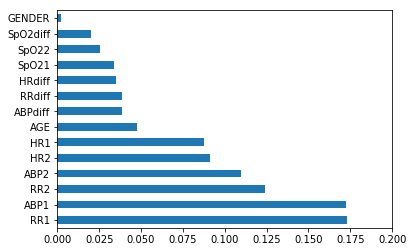

In [47]:
feat_imp = pd.Series(rf.feature_importances_, index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.2)
plt.show()

# Balancing

In [50]:
len(y_train)

1939

In [51]:
sum(y_train)

216

In [52]:
from sklearn.utils import resample

In [54]:
X_train["Y"] = y_train

/anaconda3/envs/sepsis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
X_train_0 = X_train[X_train["Y"] == 0]
X_train_1 = X_train[X_train["Y"] == 1]

In [60]:
X_train_0_new = X_train_0.sample(frac=0.2, replace=False, random_state=1)

In [61]:
len(X_train_0_new)

345

In [62]:
len(X_train_1)

216

In [63]:
X_train_new = pd.concat([X_train_0_new, X_train_1])

In [64]:
X_train_new.head()

,HR1,ABP1,RR1,SpO21,HR2,ABP2,RR2,SpO22,HRdiff,ABPdiff,RRdiff,SpO2diff,AGE,GENDER,Y
551,70.50,97.500000,21.500000,98.500000,72.00,107.00,20.00,98.0,-1.50,-9.500000,1.500000,0.500000,63.586301,0,0
1038,102.00,150.333333,16.000000,99.666667,114.40,148.80,17.60,97.8,-12.40,1.533333,-1.600000,1.866667,31.901370,0,0
1628,49.00,174.500000,16.000000,100.000000,53.00,182.00,19.00,100.0,-4.00,-7.500000,-3.000000,0.000000,48.873973,0,0
2001,76.25,119.500000,22.000000,100.000000,76.00,92.00,21.00,100.0,0.25,27.500000,1.000000,0.000000,67.742466,1,0
244,75.50,190.000000,16.166667,99.500000,77.25,184.75,16.25,100.0,-1.75,5.250000,-0.083333,-0.500000,81.975342,0,0


In [66]:
y_train_new = X_train_new["Y"]
X_train_new_X = X_train_new.drop(["Y"], axis=1)

In [67]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, class_weight="balanced").fit(X_train_new_X, y_train_new)
y_pred_lr = clf.predict(X_test)
y_score_lr = clf.predict_proba(X_test)[:,1]

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
acclr, bacclr, auclr, prelr, reclr, f1lr = classification_metrics(y_pred_lr, y_test, y_score_lr)
print(classification_metrics(y_pred_lr, y_test, y_score_lr))

(0.7814432989690722, 0.7545089358911297, 0.8271437940646007, 0.31297709923664124, 0.7192982456140351, 0.4361702127659575)


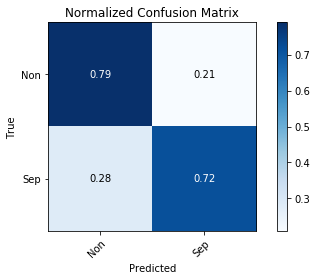

In [70]:
plot_confusion_matrix(y_test, y_pred_lr, ["Non","Sep"])

In [71]:
X_train_new_X

,HR1,ABP1,RR1,SpO21,HR2,ABP2,RR2,SpO22,HRdiff,ABPdiff,RRdiff,SpO2diff,AGE,GENDER
551,70.50,97.500000,21.500000,98.500000,72.000000,107.000000,20.000000,98.000000,-1.500000,-9.500000,1.500000,0.500000,63.586301,0
1038,102.00,150.333333,16.000000,99.666667,114.400000,148.800000,17.600000,97.800000,-12.400000,1.533333,-1.600000,1.866667,31.901370,0
1628,49.00,174.500000,16.000000,100.000000,53.000000,182.000000,19.000000,100.000000,-4.000000,-7.500000,-3.000000,0.000000,48.873973,0
2001,76.25,119.500000,22.000000,100.000000,76.000000,92.000000,21.000000,100.000000,0.250000,27.500000,1.000000,0.000000,67.742466,1
244,75.50,190.000000,16.166667,99.500000,77.250000,184.750000,16.250000,100.000000,-1.750000,5.250000,-0.083333,-0.500000,81.975342,0
1820,80.00,132.000000,16.000000,97.000000,80.000000,133.000000,15.000000,97.000000,0.000000,-1.000000,1.000000,0.000000,51.284932,0
229,80.00,178.000000,12.000000,100.000000,85.000000,117.000000,13.000000,100.000000,-5.000000,61.000000,-1.000000,0.000000,50.191781,1
815,99.00,116.000000,17.000000,99.000000,98.000000,95.000000,20.000000,98.000000,1.000000,21.000000,-3.000000,1.000000,86.676712,1
895,114.00,120.000000,25.000000,96.000000,111.000000,122.500000,19.000000,93.500000,3.000000,-2.500000,6.000000,2.500000,67.591781,0
1199,106.00,128.500000,15.500000,98.000000,108.000000,124.000000,10.000000,97.000000,-2.000000,4.500000,5.500000,1.000000,65.224658,1


# Balanced RF

In [72]:
rf = RandomForestClassifier(random_state=42, n_estimators=2000, max_depth=5, class_weight="balanced_subsample")
rf.fit(X_train_new_X, y_train_new)
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

In [73]:
accrf, baccrf, aucrf, prerf, recrf, f1rf = classification_metrics(y_pred_rf, y_test, y_score_rf)
print(classification_metrics(y_pred_rf, y_test, y_score_rf))

(0.8164948453608247, 0.7439539268732579, 0.8449335956714215, 0.3490566037735849, 0.6491228070175439, 0.4539877300613497)


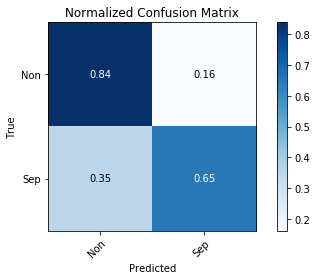

In [74]:
plot_confusion_matrix(y_test, y_pred_rf, ["Non","Sep"])

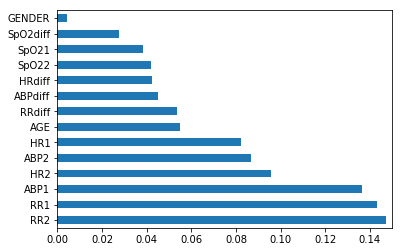

In [76]:
feat_imp = pd.Series(rf.feature_importances_, index = X_train_new_X.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.15)
plt.show()